In [1]:
import molgrid
import os
import matplotlib.pyplot as plt
import argparse
from models import *
import torch.optim as optim
import sys
import datetime
import time

In [2]:
# set some constants
batch_size = 5
datadir = '/scratch/shubham/crossdock_data'
fname = datadir+"/custom_cd.types" 
voxel_dir = 'voxel_data'
cuda = True if torch.cuda.is_available() else False

molgrid.set_random_seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# use the libmolgrid ExampleProvider to obtain shuffled, balanced, and stratified batches from a file
e = molgrid.ExampleProvider(data_root=datadir+"/structs",cache_structs=False, balanced=True,shuffle=True)
# e.cache_structs=False
e.populate(fname)

ex = e.next()
c = ex.coord_sets[0]
center = tuple(c.center())

# initialize libmolgrid GridMaker
gmaker = molgrid.GridMaker()

# e.num_types()//2 is the number of channels used for voxel representation of docked ligand
print("Number of channels: ", e.num_types()//2)
dims = gmaker.grid_dimensions(e.num_types()//2)

mgridout = molgrid.MGrid4f(*dims)
gmaker.forward(center, c, mgridout.cpu())
molgrid.write_dx("tmp.dx", mgridout[0].cpu(), center, 0.5)

print("4D Tensor Shape: ", dims)
tensor_shape = (batch_size,)+dims
print(tensor_shape)
# molgrid.write_dx("temp",gmaker,center,1)

Number of channels:  14
4D Tensor Shape:  (14, 48, 48, 48)
(5, 14, 48, 48, 48)


In [4]:
# Initialize Generator, Enocoder, VAE and LR Discriminator on GPU
generator = Generator(8, dims).to('cuda')
encoder = Encoder(vaeLike=True).to('cuda')
D_VAE = MultiDiscriminator(dims).to('cuda')
D_LR = MultiDiscriminator(dims).to('cuda')

# generator = Generator(8, dims)
# encoder = Encoder(vaeLike=True)
# D_VAE = MultiDiscriminator(dims)
# D_LR = MultiDiscriminator(dims)

# Initialise weights
generator.apply(weights_init)
D_VAE.apply(weights_init)
D_LR.apply(weights_init)

# construct optimizers for the 4 networks
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_E = optim.Adam(encoder.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_D_VAE = optim.Adam(D_VAE.parameters(), lr=0.0002, betas=[0.5, 0.999])
optimizer_D_LR = optim.Adam(D_LR.parameters(), lr=0.0002, betas=[0.5, 0.999])

# construct input tensors
input_tensor1 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
input_tensor2 = torch.zeros(tensor_shape, dtype=torch.float32, device='cuda')
# p3d = (40,40,40,40,40,40)
# print(input_tensor.shape)
float_labels = torch.zeros(batch_size, dtype=torch.float32)

In [5]:
from torch.autograd import Variable
# Tensor = torch.Tensor
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
def reparameterization(mu, logvar):
    std = torch.exp(logvar / 2)
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (mu.size(0), 8))))
    z = sampled_z * std + mu
    return z

In [6]:
total_params = sum(p.numel() for p in generator.parameters())
train_params = sum(p.numel() for p in generator.parameters() if p.requires_grad)
print("Total Parameters: ", total_params)
print("Trainable Parameters: ", train_params)

Total Parameters:  2096110
Trainable Parameters:  2096110


In [7]:
total_params = sum(p.numel() for p in D_VAE.parameters())
train_params = sum(p.numel() for p in D_VAE.parameters() if p.requires_grad)
print("Total Parameters: ", total_params)
print("Trainable Parameters: ", train_params)

Total Parameters:  877923
Trainable Parameters:  877923


In [8]:
# Loss functions
mae_loss = torch.nn.L1Loss()
opt = {
  'lambda_pixel': 10,
   'lambda_kl': 0.01,
    'lambda_latent': 0.1
}
print(opt)

{'lambda_pixel': 10, 'lambda_kl': 0.01, 'lambda_latent': 0.1}


In [9]:
import csv
with open('loss.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["G_loss", "Pixel_loss", "KL_Loss", "Latent_loss", "DVAE_loss", "DLR_loss"])
# row_list = [["G_loss", "Pixel_loss", "KL_Loss", "Latent_loss", "DVAE_loss", "DLR_loss"]

In [10]:
# train for 500 iterations
# G_loss, Pixel_loss, KL_Loss, Latent_loss, DVAE_loss, DLR_loss = [],[],[],[],[],[]
for iteration in range(500):
    # load data
    batch1 = e.next_batch(batch_size)
    batch2 = e.next_batch(batch_size)
    # libmolgrid can interoperate directly with Torch tensors, using views over the same memory.
    # internally, the libmolgrid GridMaker can use libmolgrid Transforms to apply random rotations and translations for data augmentation
    # the user may also use libmolgrid Transforms directly in python
    gmaker.forward(batch1, input_tensor1, 0, random_rotation=False)
    gmaker.forward(batch2, input_tensor2, 0, random_rotation=False)
    
    # Training the encoder and generator
    optimizer_E.zero_grad()
    optimizer_G.zero_grad()
    
    mu, logvar = encoder(input_tensor2)
    encoded_z = reparameterization(mu, logvar)

    fake_ligands = generator(input_tensor1, encoded_z)
    
    # L1 loss for measuring degree of diff between generated outputs and the actual input
    loss_pixel = mae_loss(fake_ligands, input_tensor2)
#     Pixel_loss.append(loss_pixel)
    
    # KL divergence between the distribution learned by the encoder and a random Gaussian
    loss_kl = 0.5 * torch.sum(torch.exp(logvar) + mu ** 2 - logvar - 1)
#     KL_Loss.append(loss_kl)
    
    # discrimantor distinguishing b/w fake and real for cVAE GAN
    loss_VAE_GAN = D_VAE.compute_loss(fake_ligands, 1)
    
    # sample z values from the Gaussian distribution with mu,sigma = 0, 1
    sampled_z = Variable(Tensor(np.random.normal(0, 1, (input_tensor1.size(0), 8))))
    fake_ligands1 = generator(input_tensor1, sampled_z)
    
    # discrimantor distinguishing b/w fake and real for cLR GAN
    loss_LR_GAN = D_LR.compute_loss(fake_ligands1, 1)
    
    # Total Loss: Generator + Encoder
    loss_GE = loss_VAE_GAN + loss_LR_GAN + opt['lambda_pixel'] * loss_pixel + opt['lambda_kl'] * loss_kl
#     G_loss.append(loss_GE)
    
    loss_GE.backward(retain_graph=True)
    optimizer_E.step()
    
    # Generator only loss
    _mu, _ = encoder(fake_ligands1)
    loss_latent = opt['lambda_latent'] * mae_loss(_mu, sampled_z)
#     Latent_loss.append(loss_latent)
    
    loss_latent.backward()
    optimizer_G.step()
    
    # Train the discriminator for the cVAE GAN.
    optimizer_D_VAE.zero_grad()
    loss_D_VAE = D_VAE.compute_loss(fake_ligands.detach(), 0) + D_VAE.compute_loss(input_tensor2, 1)
#     DVAE_loss.append(loss_D_VAE)
    
    loss_D_VAE.backward()
    optimizer_D_VAE.step()
    
    # Train the discriminator for the cLR GAN.
    optimizer_D_LR.zero_grad()
    loss_D_LR = D_LR.compute_loss(fake_ligands1.detach(), 0) + D_LR.compute_loss(input_tensor2, 1)
#     DLR_loss.append(loss_D_LR)
    
    loss_D_LR.backward()
    optimizer_D_LR.step()
    with open('loss.csv', 'a') as file:
        writer = csv.writer(file)
        writer.writerow([loss_GE.item(), loss_pixel.item(), loss_kl.item(), loss_latent.item(), loss_D_VAE.item(), loss_D_LR.item()])
    
    sys.stdout.write(
            "\r[Epoch %d/%d] [G loss: %.3f, pixel loss: %.3f, kl loss: %.3f, latent loss: %.3f D_VAE loss: %.3f, D_LR loss: %.3f]"
            % (
                iteration,
                500,
                loss_GE.item(),
                loss_pixel.item(),
                loss_kl.item(),
                loss_latent.item(),
                loss_D_VAE.item(),
                loss_D_LR.item()
            )
    )

[Epoch 499/500] [G loss: 3.096, pixel loss: 0.009, kl loss: 0.059, latent loss: 0.084 D_VAE loss: 0.667, D_LR loss: 0.695]]]

In [11]:
data = np.genfromtxt("loss.csv", delimiter=",", names=["G_loss", "Pixel_loss", "KL_Loss", "Latent_loss", "DVAE_loss", "DLR_loss"])

In [12]:
import numpy as np
from matplotlib.pyplot import figure



In [13]:
x = np.arange(501)

In [14]:
def plot(x,y,label):
    figure(figsize=(8, 6), dpi=80)
    plt.plot(x,data[y])
    plt.title(label)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

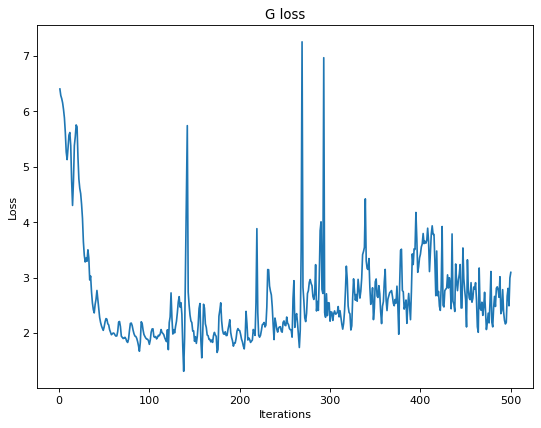

In [15]:
plot(x,"G_loss","G loss")

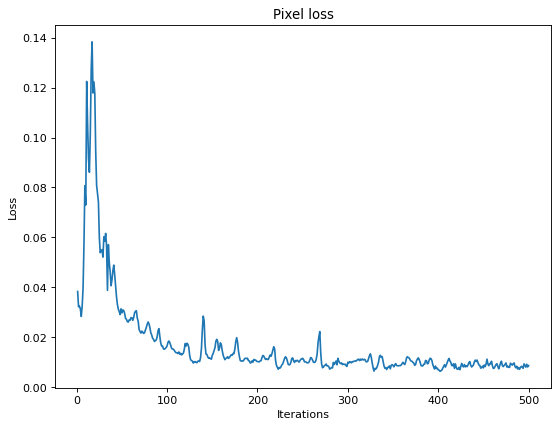

In [16]:
plot(x,"Pixel_loss","Pixel loss")

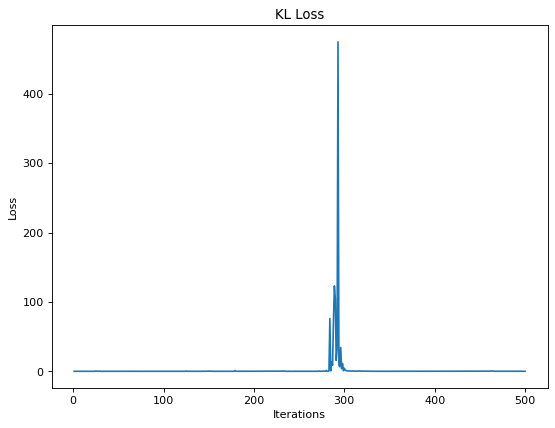

In [17]:
plot(x,"KL_Loss","KL Loss")

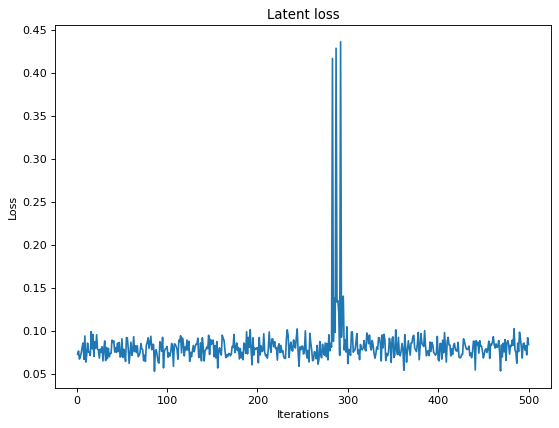

In [18]:
plot(x,"Latent_loss","Latent loss")

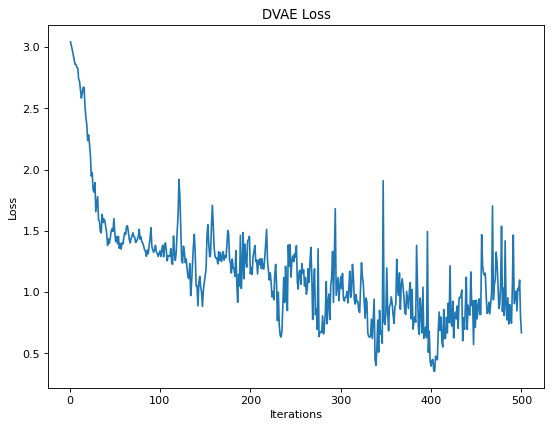

In [19]:
plot(x,"DVAE_loss","DVAE Loss")

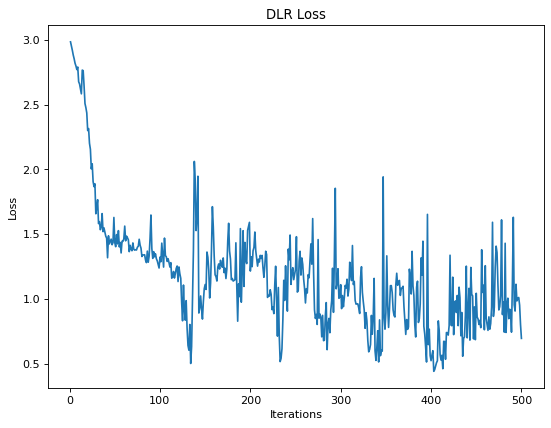

In [20]:
plot(x,"DLR_loss","DLR Loss")